# Advanced Training

In [1]:
!pip install pytorch-model-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from torch.optim import Adam
import torch.optim as optim

from pytorch_model_summary import summary

import torchvision.transforms as transforms
from typing import Text, Dict
import numpy as np
from tqdm import tqdm 
import time
import json
import matplotlib.pyplot as plt
import os

## Classification Network

In [3]:
# Dataset
IMAGE_SIZE = 32
N_CLASSES = 10
BATCH_SIZE = 128

# Network
IN_CHANNELS = 3
OUT_CHANNELS = 4
KERNEL_SIZE = 5
POOL_SIZE = 2

# Training
LEARNING_RATE = 0.01
EPOCHS = 10

# Others
seed = 2022
model_name = 'CIFAR10 Classification Model'
save_dir = './'


In [4]:
def extract_dataset(batch_size: int):

  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  # Dataset
  training_data = datasets.CIFAR10(root='data',
                                  download=True,
                                  train=True,
                                  transform=transform)

  valid_data = datasets.CIFAR10(root='data',
                              download=True,
                              train=False,
                              transform=transform)

  # Dataloader

  train_dataloader = DataLoader(dataset=training_data,
                                batch_size=batch_size,
                                shuffle=True,
                                drop_last=True)

  valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True)

  dataloader = {'train': train_dataloader,
                'valid': valid_dataloader}

  return dataloader


dataloader = extract_dataset(BATCH_SIZE)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [5]:
class ClassificationNetwork(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, pool_size, n_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.pool_1 = nn.MaxPool2d(pool_size, pool_size)
        self.conv_2 = nn.Conv2d(out_channels, out_channels*2, kernel_size)
        self.pool_2 = nn.MaxPool2d(pool_size, pool_size)

        input_size = out_channels*2 * kernel_size * kernel_size
        self.fc1 = nn.Linear(input_size, input_size // 4)
        self.fc2 = nn.Linear(input_size // 4, input_size // 8)
        self.fc3 = nn.Linear(input_size // 8, n_classes)

    def forward(self, x):
        x = self.pool_1(F.relu(self.conv_1(x)))
        x = self.pool_2(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))

        return x

In [6]:
network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()

summary(network, torch.zeros((BATCH_SIZE, IN_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)), show_input=True, show_hierarchical=True,
        print_summary=True)

print()

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
          Conv2d-1     [128, 3, 32, 32]             304             304
       MaxPool2d-2     [128, 4, 28, 28]               0               0
          Conv2d-3     [128, 4, 14, 14]             808             808
       MaxPool2d-4     [128, 8, 10, 10]               0               0
          Linear-5           [128, 200]          10,050          10,050
          Linear-6            [128, 50]           1,275           1,275
          Linear-7            [128, 25]             260             260
Total params: 12,697
Trainable params: 12,697
Non-trainable params: 0
------------------------------------------------------------------------


====================================== Hierarchical Summary ======================================

ClassificationNetwork(
  (conv_1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1)), 304 params
  (pool_1):

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
class Model:

    def __init__(self,
                 name: Text,
                 network: nn.Module,
                 dataloader: Dict[Text, DataLoader],
                 loss_function,
                 seed: int,
                 save_dir: Text,
                 device = None
                 ):

        self.name = name
        self.id = time.time()
        self.network = network.to(device)
        self.dataloader = dataloader
        self.loss_function = loss_function()
        self.optimizer = None

        self.save_dir = save_dir
        self.filepath = None
        self.device = device

        self.epoch_count = []
        self.train_losses, self.valid_losses = [], []

        torch.manual_seed(seed)

    def load_optimizer(self,
                       optimizer: Optimizer,
                       lr: float,
                       weight_decay = 0):
        self.optimizer = optimizer(self.network.parameters(),
                                   lr=lr,
                                   weight_decay=weight_decay)

    def train(self,
              epochs: int
              ):

        for epoch in tqdm(range(epochs), desc=' > Epochs'):
            self.epoch_count.append(epoch)
            
            # Training Step
            train_loss, valid_loss = self.training_step()
            
            # Plot Losses
            plot_loss(self.train_losses, self.valid_losses, epoch)

        return

    def training_step(self):
        train_loss = self.train_one_epoch()
        valid_loss = self.validate_one_epoch()

        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)

        return train_loss, valid_loss

    def train_one_epoch(self):
      self.network.train()

      losses = []

      for images, labels in self.dataloader['train']:

          images = images.to(self.device)
          labels = labels.to(self.device)

          output = self.network(images)
          loss = self.loss_function(output, labels)
          losses.append(loss.item())

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

      return np.mean(losses)

    def validate_one_epoch(self):
      self.network.eval()

      losses = []

      with torch.no_grad():
          for images, labels in self.dataloader['valid']:

              images = images.to(self.device)
              labels = labels.to(self.device)

              output = self.network(images)
              loss = self.loss_function(output, labels)
              losses.append(loss.item())

          return np.mean(losses)

    def predict(self, x):
        print(f' > Input image shape: {x.shape}')
        plt.imshow(x)
        plt.show()

        x = torch.Tensor(x)
        x = x.transpose(0,2)
        x = x.transpose(1,2)
        x = x.unsqueeze(0)

        print(f'\n\n > Image shape preprocessed: {x.shape}\n')

        with torch.no_grad():
          print('--- Inference ---\n')
          output = self.network(x)
          output = output.squeeze()
          print(f' > Output shape: {output.shape}')
          print(f' > Output value: {output}\n\n')

        return output

    def save(self):
        checkpoint = {'epoch': self.epoch_count[-1],
                      'train_loss': self.train_losses[-1],
                      'valid_loss': self.valid_losses[-1],
                      'losses': {'train': self.train_losses,
                                  'valid': self.valid_losses},
                      'network_state': self.network.state_dict(),
                      'id': self.id,
                      'name': self.name,
                      'optimizer': {'name': str(self.optimizer),
                                    'state': self.optimizer.state_dict()},
                      'loss': str(self.loss_function)}

        folder_save = f'{self.save_dir}{self.name}|{self.id}/'
        ensure_folder(folder_save)

        filename = f'{self.name}|{self.id}.pth'
        model_path = f'{folder_save}{filename}'
        torch.save(checkpoint, model_path)

    @staticmethod
    def load(model_path, model_name, network, loss_function, seed, save_dir, learning_rate, dataloader):
      checkpoint = torch.load(model_path)
      
      loaded_model = Model(name=model_name,
                            network=network, 
                            loss_function=loss_function,
                            dataloader=dataloader,
                            seed=seed,
                            save_dir=save_dir)

      # Load state dicts
      loaded_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)
      loaded_model.network.load_state_dict(checkpoint['network_state'])
      loaded_model.optimizer.load_state_dict(checkpoint['optimizer']['state'])

      return loaded_model


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        return True

    return False

def plot_loss(train_losses, valid_losses, epoch):
  plt.plot(train_losses, c='r', label='Training Loss')
  plt.plot(valid_losses, c='b', label='Validation Loss')

  plt.legend()
  plt.show()

## Init Weights

### One Weights

In [8]:
def init_weights_one(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.ones_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.ones_(m.weight)
        m.bias.data.fill_(0.01)
    

### Xavier Weights

In [9]:
def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    

In [10]:
# Dataset
IMAGE_SIZE = 32
N_CLASSES = 10
BATCH_SIZE = 128

# Network
IN_CHANNELS = 3
OUT_CHANNELS = 4
KERNEL_SIZE = 5
POOL_SIZE = 2

# Training
LEARNING_RATE = 0.001
EPOCHS = 10

# Others
seed = 2022
model_name = 'CIFAR10 Classification Model'
save_dir = './'


### Test Weights

### Test Init One weights

In [ ]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_one)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

Files already downloaded and verified
Files already downloaded and verified


 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


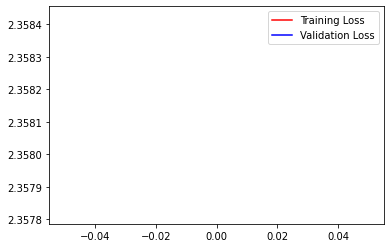

 > Epochs:  10%|█         | 1/10 [00:23<03:32, 23.64s/it]

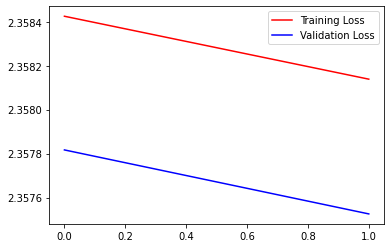

 > Epochs:  20%|██        | 2/10 [00:46<03:05, 23.18s/it]

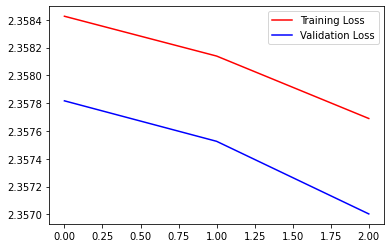

 > Epochs:  30%|███       | 3/10 [01:09<02:41, 23.14s/it]

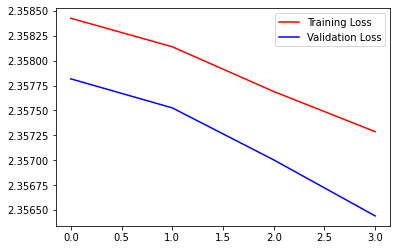

 > Epochs:  40%|████      | 4/10 [01:32<02:18, 23.12s/it]

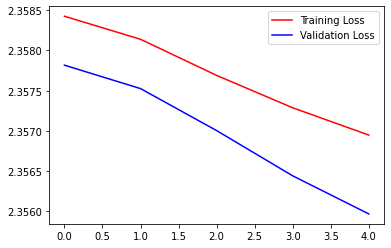

 > Epochs:  50%|█████     | 5/10 [01:56<01:56, 23.29s/it]

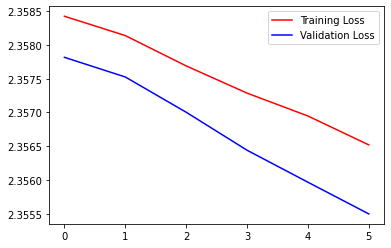

 > Epochs:  60%|██████    | 6/10 [02:19<01:33, 23.32s/it]

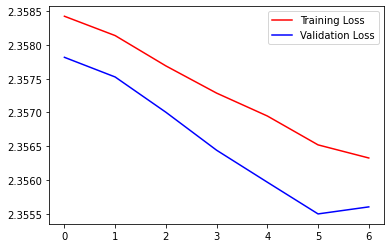

 > Epochs:  70%|███████   | 7/10 [02:42<01:09, 23.33s/it]

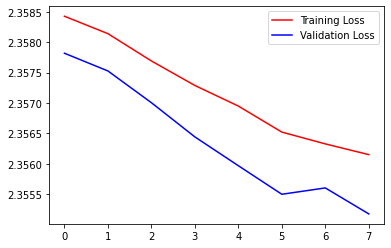

 > Epochs:  80%|████████  | 8/10 [03:06<00:46, 23.33s/it]

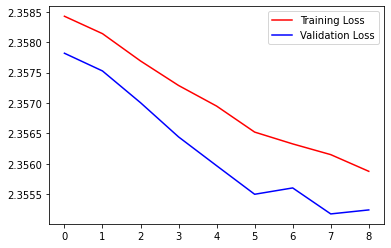

 > Epochs:  90%|█████████ | 9/10 [03:29<00:23, 23.27s/it]

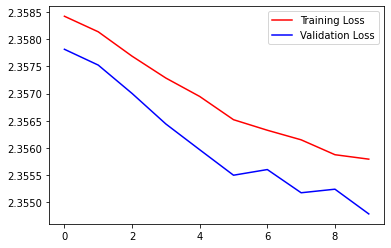

 > Epochs: 100%|██████████| 10/10 [03:53<00:00, 23.31s/it]


In [ ]:
# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS)

### Test xavier init weights

In [ ]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


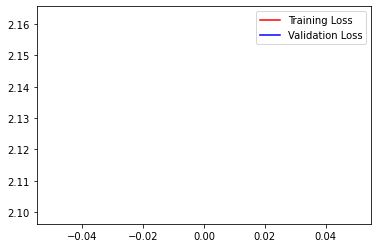

 > Epochs:  10%|█         | 1/10 [00:23<03:31, 23.52s/it]

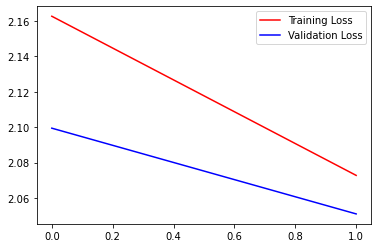

 > Epochs:  20%|██        | 2/10 [00:46<03:07, 23.46s/it]

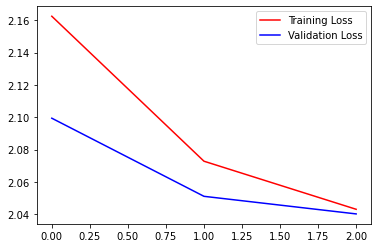

 > Epochs:  30%|███       | 3/10 [01:10<02:43, 23.40s/it]

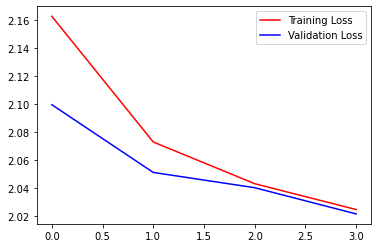

 > Epochs:  40%|████      | 4/10 [01:33<02:21, 23.51s/it]

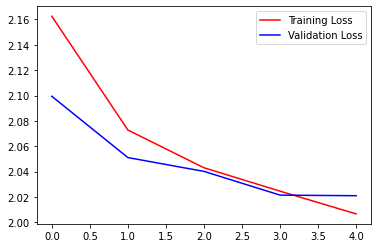

 > Epochs:  50%|█████     | 5/10 [01:57<01:57, 23.60s/it]

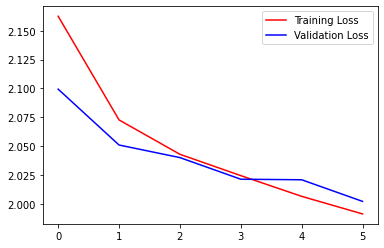

 > Epochs:  60%|██████    | 6/10 [02:21<01:34, 23.73s/it]

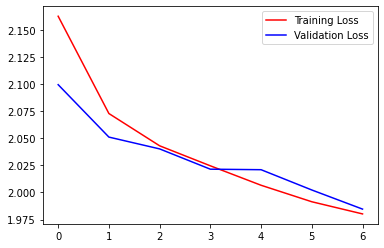

 > Epochs:  70%|███████   | 7/10 [02:47<01:13, 24.37s/it]

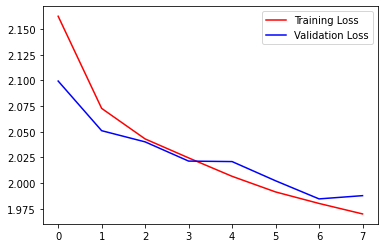

 > Epochs:  80%|████████  | 8/10 [03:12<00:48, 24.45s/it]

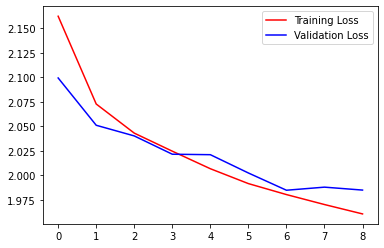

 > Epochs:  90%|█████████ | 9/10 [03:38<00:25, 25.18s/it]

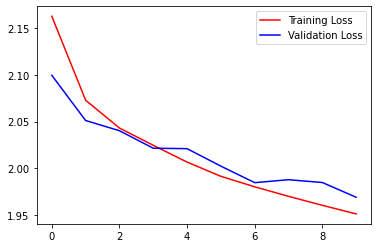

 > Epochs: 100%|██████████| 10/10 [04:03<00:00, 24.34s/it]


In [ ]:
# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS)

## Loss Evaluation: Visdom

- Install on your pc the jupyter notebook (pip install notebook)
- Create a session with jupyter notebook
    
      jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

----

      jupyter notebook 
        --NotebookApp.allow_origin='https://colab.research.google.com' 
        --port=8888 
        --NotebookApp.port_retries=0


In [ ]:
!pip install visdom

In [ ]:
!python -m visdom.server

In [ ]:
from visdom import Visdom

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}

    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]),
                                                 Y=np.array([y,y]),
                                                 env=self.env,
                                                 opts=dict(
                                                              legend=[split_name],
                                                              title=title_name,
                                                              xlabel='Epochs',
                                                              ylabel=var_name
                                                          ))
        else:
            self.viz.line(X=np.array([x]),
                          Y=np.array([y]),
                          env=self.env,
                          win=self.plots[var_name],
                          name=split_name,
                          update = 'append')

plotter = VisdomLinePlotter(env_name='Loss Functions')

def plot_loss(train_losses, valid_losses, epoch):
  plotter.plot('loss', 'train', 'Loss Function',
               epoch, train_losses[-1])
  plotter.plot('loss', 'valid', 'Loss Function',
               epoch, valid_losses[-1])

Setting up a new session...


In [ ]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS)

## Early Stopping

In [11]:
def early_stopping(valid_losses,
                   delta: float):
  
  if len(valid_losses) > 1 and \
      valid_losses[-1] > valid_losses[-2] + delta:
    return True
  else:
    return False
      

In [12]:
class Model:

    def __init__(self,
                 name: Text,
                 network: nn.Module,
                 dataloader: Dict[Text, DataLoader],
                 loss_function,
                 seed: int,
                 save_dir: Text,
                 device = None
                 ):

        self.name = name
        self.id = time.time()
        self.network = network.to(device)
        self.dataloader = dataloader
        self.loss_function = loss_function()
        self.optimizer = None

        self.save_dir = save_dir
        self.filepath = None
        self.device = device

        self.epoch_count = []
        self.train_losses, self.valid_losses = [], []

        torch.manual_seed(seed)

    def load_optimizer(self,
                       optimizer: Optimizer,
                       lr: float,
                       weight_decay = 0):
        self.optimizer = optimizer(self.network.parameters(),
                                   lr=lr,
                                   weight_decay=weight_decay)

    def train(self,
              epochs: int,
              patience: int = 1,
              delta: float = 0
              ):

        curr_patience = patience

        for epoch in tqdm(range(epochs), desc=' > Epochs'):
            self.epoch_count.append(epoch)
            
            # Training Step
            train_loss, valid_loss = self.training_step()
            
            # Plot Losses
            plot_loss(self.train_losses, self.valid_losses, epoch)

            # Early stopping check
            es = early_stopping(self.valid_losses, delta)

            if es and curr_patience -1 > 0:
              curr_patience -= 1
            
            elif es and curr_patience -1 == 0:
              print('\n\nEarly stopping enabled\n\n')
              break

            else:
              # Init patience
              curr_patience = patience
              self.save()

        return

    def training_step(self):
        train_loss = self.train_one_epoch()
        valid_loss = self.validate_one_epoch()

        self.train_losses.append(train_loss)
        self.valid_losses.append(valid_loss)

        return train_loss, valid_loss

    def train_one_epoch(self):
      self.network.train()

      losses = []

      for images, labels in self.dataloader['train']:

          images = images.to(self.device)
          labels = labels.to(self.device)

          output = self.network(images)
          loss = self.loss_function(output, labels)
          losses.append(loss.item())

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

      return np.mean(losses)

    def validate_one_epoch(self):
      self.network.eval()

      losses = []

      with torch.no_grad():
          for images, labels in self.dataloader['valid']:

              images = images.to(self.device)
              labels = labels.to(self.device)

              output = self.network(images)
              loss = self.loss_function(output, labels)
              losses.append(loss.item())

          return np.mean(losses)

    def predict(self, x):
        print(f' > Input image shape: {x.shape}')
        plt.imshow(x)
        plt.show()

        x = torch.Tensor(x)
        x = x.transpose(0,2)
        x = x.transpose(1,2)
        x = x.unsqueeze(0)

        print(f'\n\n > Image shape preprocessed: {x.shape}\n')

        with torch.no_grad():
          print('--- Inference ---\n')
          output = self.network(x)
          output = output.squeeze()
          print(f' > Output shape: {output.shape}')
          print(f' > Output value: {output}\n\n')

        return output

    def save(self):
        checkpoint = {'epoch': self.epoch_count[-1],
                      'train_loss': self.train_losses[-1],
                      'valid_loss': self.valid_losses[-1],
                      'losses': {'train': self.train_losses,
                                  'valid': self.valid_losses},
                      'network_state': self.network.state_dict(),
                      'id': self.id,
                      'name': self.name,
                      'optimizer': {'name': str(self.optimizer),
                                    'state': self.optimizer.state_dict()},
                      'loss': str(self.loss_function)}

        folder_save = f'{self.save_dir}{self.name}|{self.id}/'
        ensure_folder(folder_save)

        filename = f'{self.name}|{self.id}.pth'
        model_path = f'{folder_save}{filename}'
        torch.save(checkpoint, model_path)

    @staticmethod
    def load(model_path, model_name, network, loss_function, seed, save_dir, learning_rate, dataloader):
      checkpoint = torch.load(model_path)
      
      loaded_model = Model(name=model_name,
                            network=network, 
                            loss_function=loss_function,
                            dataloader=dataloader,
                            seed=seed,
                            save_dir=save_dir)

      # Load state dicts
      loaded_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)
      loaded_model.network.load_state_dict(checkpoint['network_state'])
      loaded_model.optimizer.load_state_dict(checkpoint['optimizer']['state'])

      return loaded_model


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        return True

    return False

def plot_loss(train_losses, valid_losses, epoch):
  plt.plot(train_losses, c='r', label='Training Loss')
  plt.plot(valid_losses, c='b', label='Validation Loss')

  plt.legend()
  plt.show()

### Test Early stopping

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
 > Epochs:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


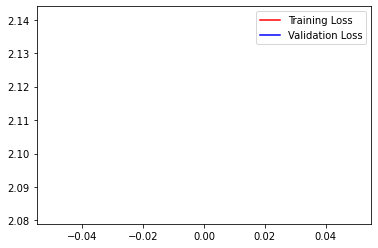

 > Epochs:   3%|▎         | 1/30 [00:22<11:04, 22.91s/it]

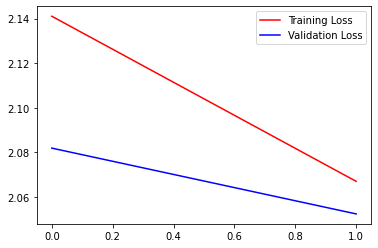

 > Epochs:   7%|▋         | 2/30 [00:45<10:40, 22.87s/it]

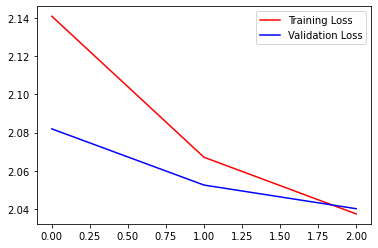

 > Epochs:  10%|█         | 3/30 [01:08<10:17, 22.88s/it]

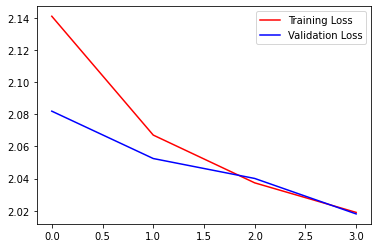

 > Epochs:  13%|█▎        | 4/30 [01:31<09:55, 22.89s/it]

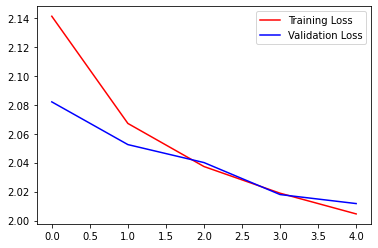

 > Epochs:  17%|█▋        | 5/30 [01:54<09:31, 22.88s/it]

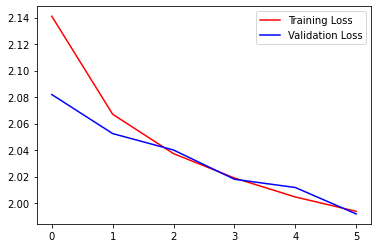

 > Epochs:  20%|██        | 6/30 [02:17<09:09, 22.90s/it]

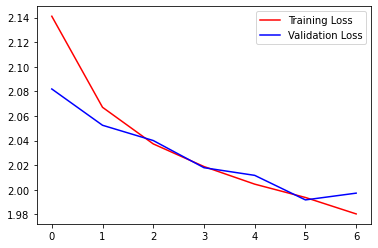

 > Epochs:  20%|██        | 6/30 [02:40<10:40, 26.70s/it]



Early stopping enabled




In [ ]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=0.001)

# Training
nn_model.train(30)

## Choosing Hyperparameters

### Loss check

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Dataset
training_data = datasets.CIFAR10(root='data',
                                download=True,
                                train=True,
                                transform=transform)

valid_data = datasets.CIFAR10(root='data',
                            download=True,
                            train=False,
                            transform=transform)


subset = list(range(0, 1000))

subset_train_data = torch.utils.data.Subset(training_data, subset)
subset_valid_data = torch.utils.data.Subset(valid_data, subset)

trainloader = torch.utils.data.DataLoader(subset_train_data, batch_size=BATCH_SIZE,
                                            shuffle=True)
validloader = torch.utils.data.DataLoader(subset_valid_data, batch_size=BATCH_SIZE,
                                            shuffle=True)

subset_dataloader = {'train': trainloader,
                     'valid': validloader}

Files already downloaded and verified
Files already downloaded and verified


In [29]:
LEARNING_RATE = 0.01
EPOCHS = 10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


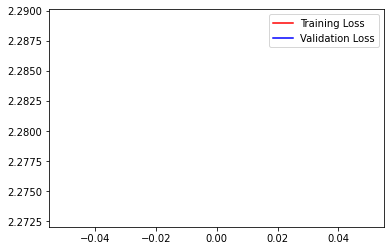

 > Epochs:  10%|█         | 1/10 [00:00<00:07,  1.21it/s]

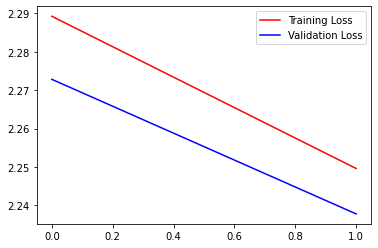

 > Epochs:  20%|██        | 2/10 [00:01<00:06,  1.21it/s]

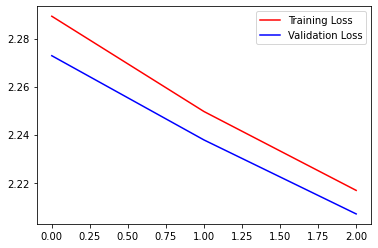

 > Epochs:  30%|███       | 3/10 [00:02<00:05,  1.18it/s]

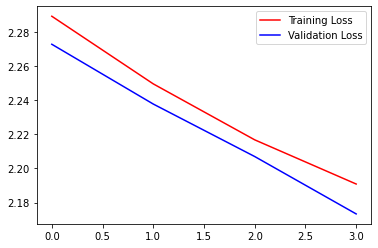

 > Epochs:  40%|████      | 4/10 [00:03<00:05,  1.18it/s]

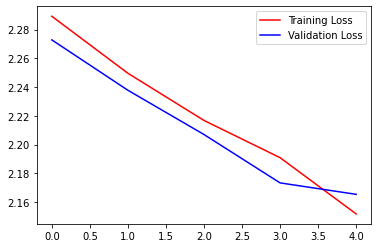

 > Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.19it/s]

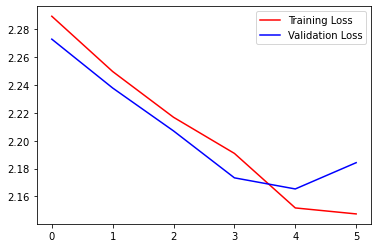

 > Epochs:  60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

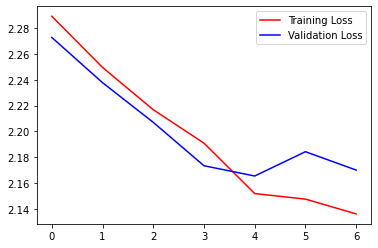

 > Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.18it/s]

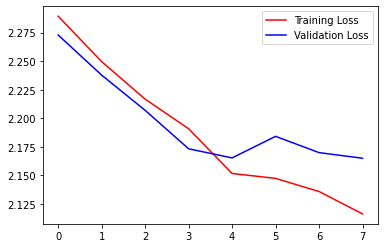

 > Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.12it/s]

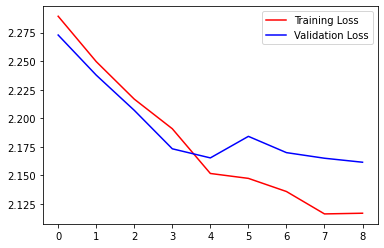

 > Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]

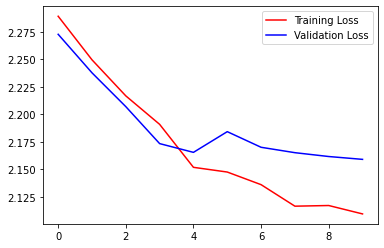

 > Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


In [30]:
network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = subset_dataloader,
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam, lr=LEARNING_RATE)

# Training
nn_model.train(EPOCHS, patience=99)

### Consolidate LR

In [33]:
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001

EPOCHS = 10

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


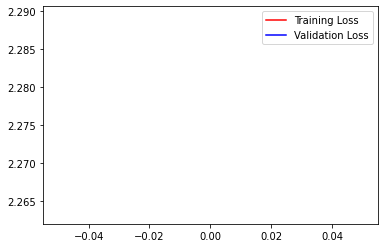

 > Epochs:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]

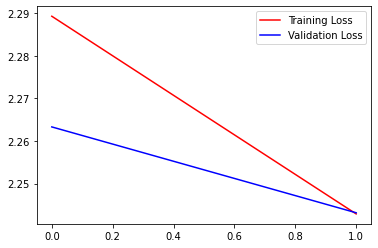

 > Epochs:  20%|██        | 2/10 [00:01<00:06,  1.15it/s]

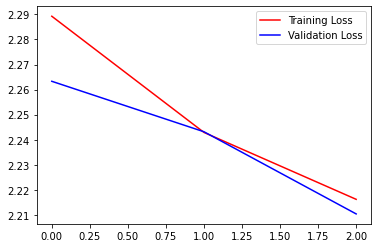

 > Epochs:  30%|███       | 3/10 [00:02<00:06,  1.14it/s]

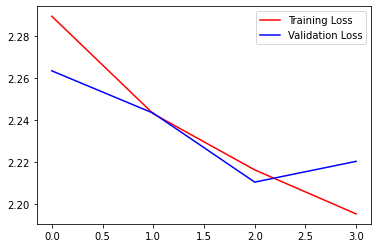

 > Epochs:  40%|████      | 4/10 [00:03<00:05,  1.17it/s]

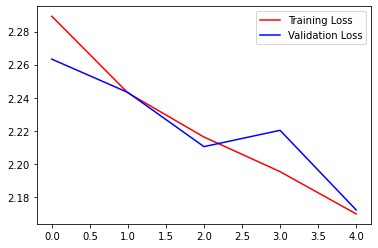

 > Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.17it/s]

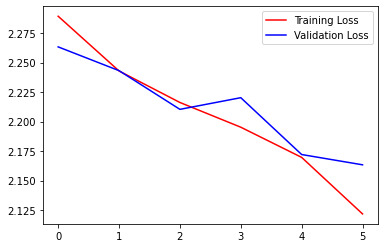

 > Epochs:  60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

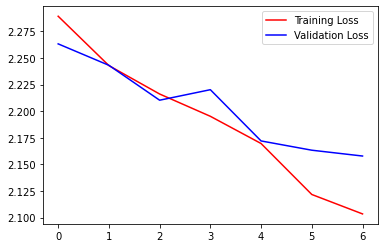

 > Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.20it/s]

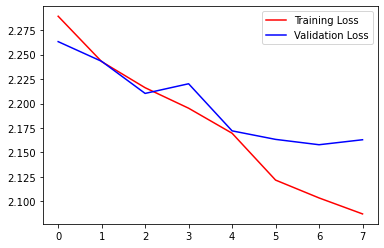

 > Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

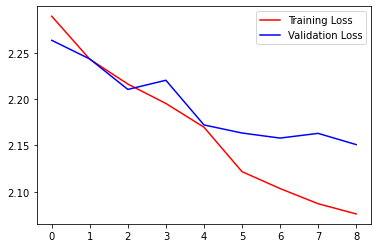

 > Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.22it/s]

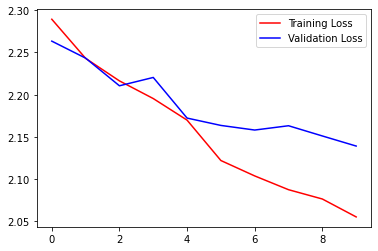

 > Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [34]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = subset_dataloader, # subset_dataloader just for showing fast result, it would contain the entire training data
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam,
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY)

# Training
nn_model.train(EPOCHS, patience=99)

### Consolidate Model Setup

In [39]:
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.00001

EPOCHS = 10

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
 > Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


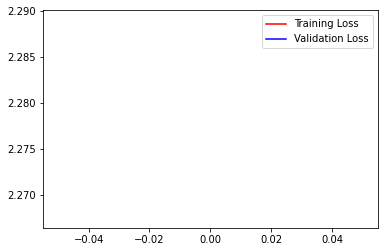

 > Epochs:  10%|█         | 1/10 [00:00<00:07,  1.14it/s]

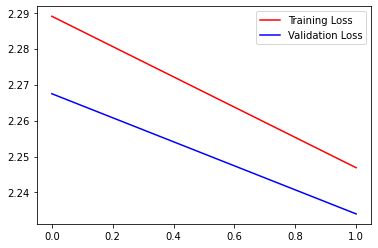

 > Epochs:  20%|██        | 2/10 [00:01<00:07,  1.13it/s]

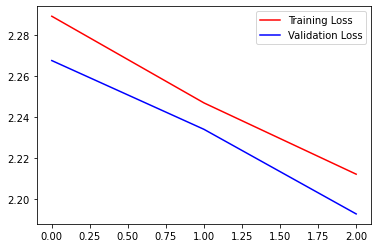

 > Epochs:  30%|███       | 3/10 [00:02<00:06,  1.14it/s]

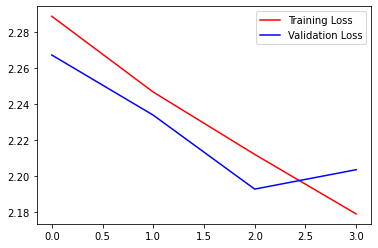

 > Epochs:  40%|████      | 4/10 [00:03<00:05,  1.15it/s]

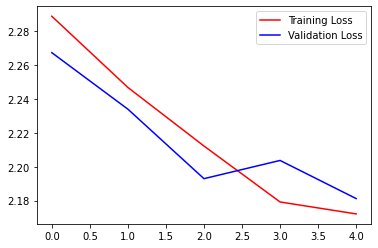

 > Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.15it/s]

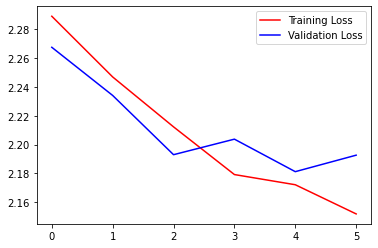

 > Epochs:  60%|██████    | 6/10 [00:05<00:03,  1.14it/s]

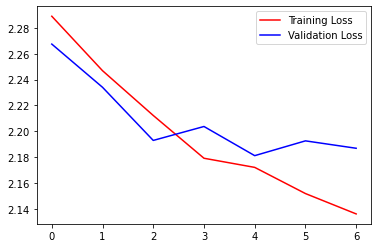

 > Epochs:  70%|███████   | 7/10 [00:06<00:02,  1.14it/s]

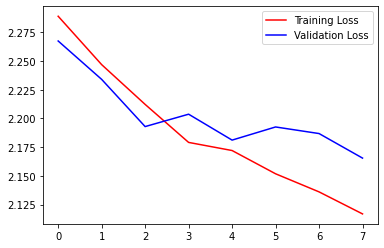

 > Epochs:  80%|████████  | 8/10 [00:07<00:01,  1.13it/s]

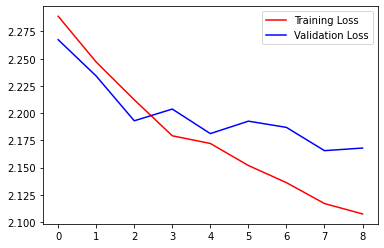

 > Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

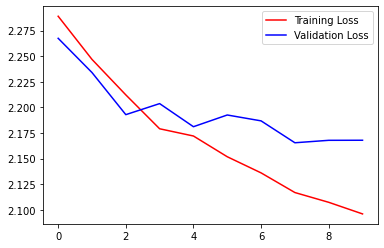

 > Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


In [40]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = subset_dataloader, # subset_dataloader just for showing fast result, it would contain the entire training data
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam,
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY)

# Training
nn_model.train(EPOCHS, patience=99)

### Full Training

In [47]:
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0.0001

EPOCHS = 100

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
 > Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


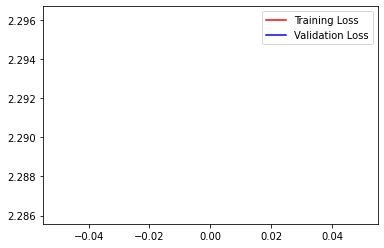

 > Epochs:   1%|          | 1/100 [00:00<01:23,  1.18it/s]

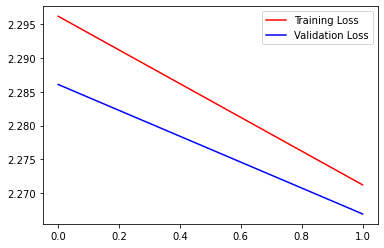

 > Epochs:   2%|▏         | 2/100 [00:01<01:22,  1.19it/s]

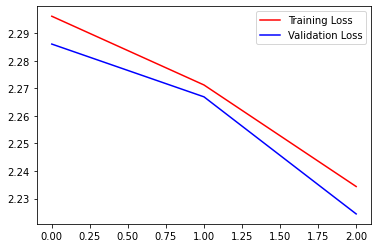

 > Epochs:   3%|▎         | 3/100 [00:02<01:22,  1.18it/s]

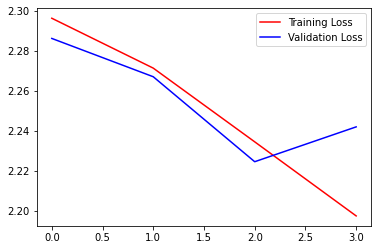

 > Epochs:   4%|▍         | 4/100 [00:03<01:21,  1.18it/s]

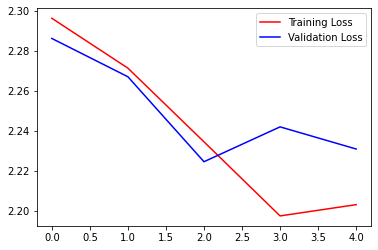

 > Epochs:   5%|▌         | 5/100 [00:04<01:20,  1.18it/s]

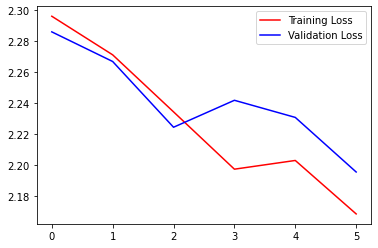

 > Epochs:   6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

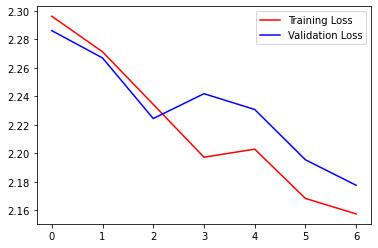

 > Epochs:   7%|▋         | 7/100 [00:05<01:18,  1.18it/s]

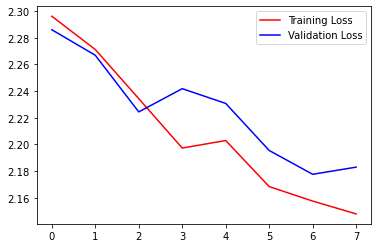

 > Epochs:   8%|▊         | 8/100 [00:06<01:18,  1.17it/s]

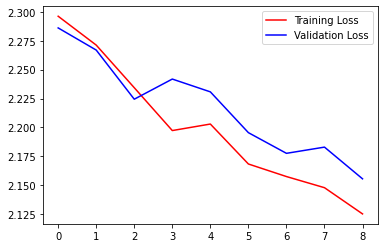

 > Epochs:   9%|▉         | 9/100 [00:07<01:18,  1.16it/s]

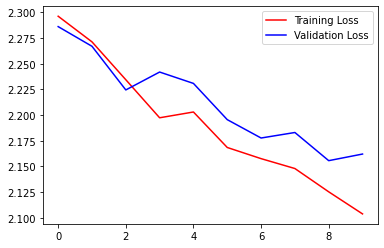

 > Epochs:  10%|█         | 10/100 [00:08<01:16,  1.17it/s]

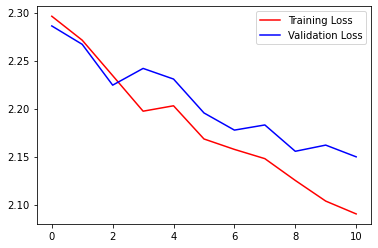

 > Epochs:  11%|█         | 11/100 [00:09<01:16,  1.17it/s]

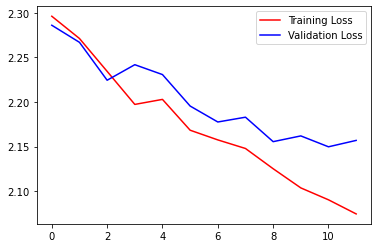

 > Epochs:  12%|█▏        | 12/100 [00:10<01:15,  1.17it/s]

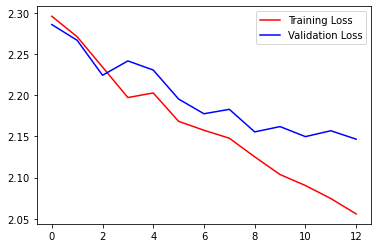

 > Epochs:  13%|█▎        | 13/100 [00:11<01:18,  1.12it/s]

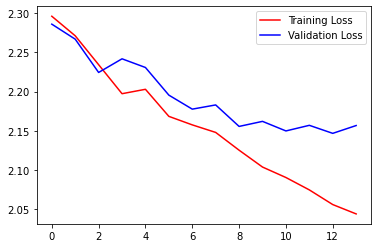

 > Epochs:  14%|█▍        | 14/100 [00:12<01:14,  1.15it/s]

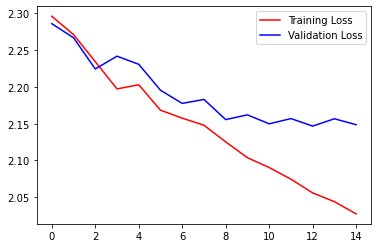

 > Epochs:  15%|█▌        | 15/100 [00:12<01:13,  1.16it/s]

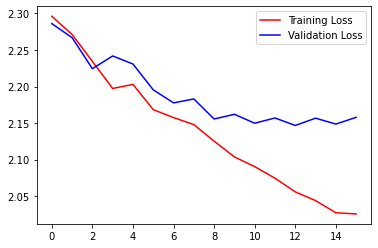

 > Epochs:  16%|█▌        | 16/100 [00:13<01:12,  1.16it/s]

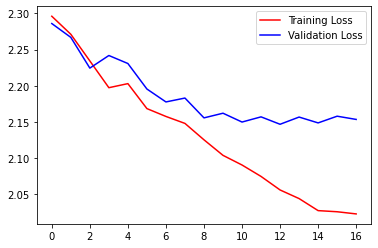

 > Epochs:  17%|█▋        | 17/100 [00:14<01:10,  1.18it/s]

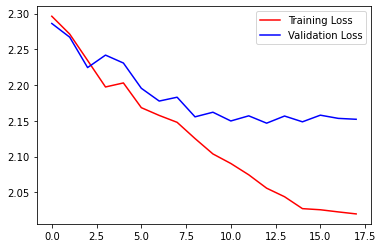

 > Epochs:  18%|█▊        | 18/100 [00:15<01:09,  1.19it/s]

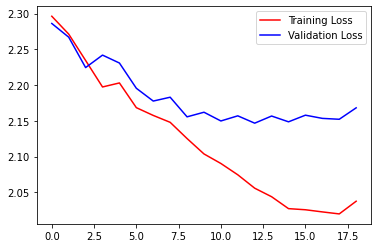

 > Epochs:  19%|█▉        | 19/100 [00:16<01:08,  1.18it/s]

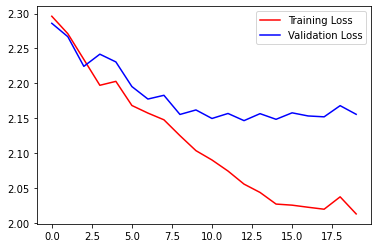

 > Epochs:  20%|██        | 20/100 [00:17<01:07,  1.18it/s]

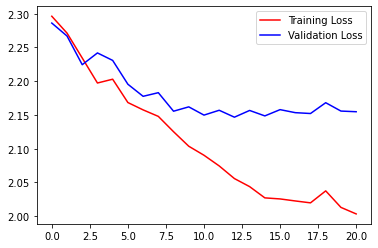

 > Epochs:  21%|██        | 21/100 [00:17<01:07,  1.18it/s]

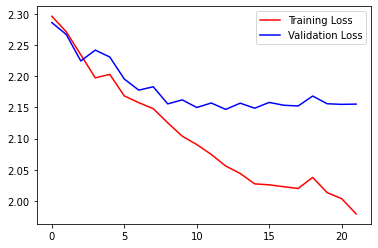

 > Epochs:  22%|██▏       | 22/100 [00:18<01:06,  1.18it/s]

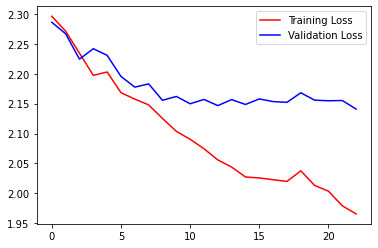

 > Epochs:  23%|██▎       | 23/100 [00:19<01:05,  1.17it/s]

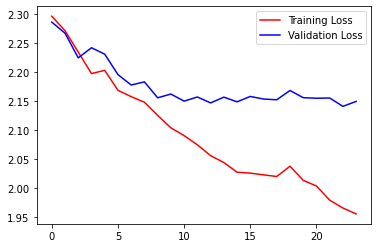

 > Epochs:  24%|██▍       | 24/100 [00:20<01:05,  1.17it/s]

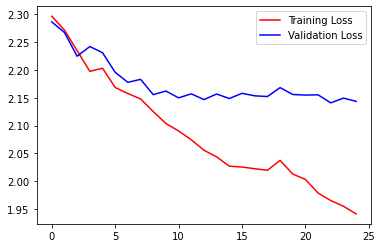

 > Epochs:  25%|██▌       | 25/100 [00:21<01:04,  1.17it/s]

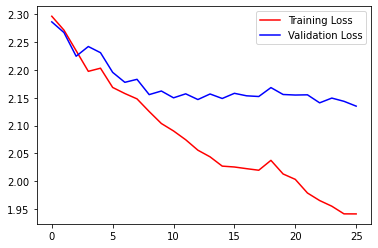

 > Epochs:  26%|██▌       | 26/100 [00:22<01:05,  1.12it/s]

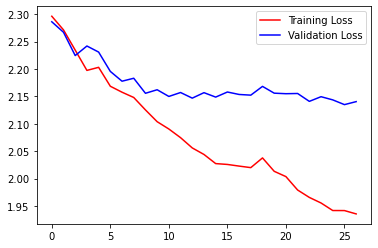

 > Epochs:  27%|██▋       | 27/100 [00:23<01:03,  1.14it/s]

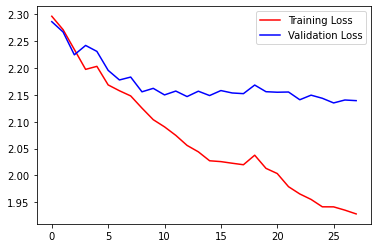

 > Epochs:  28%|██▊       | 28/100 [00:24<01:02,  1.15it/s]

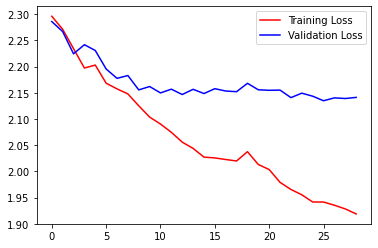

 > Epochs:  29%|██▉       | 29/100 [00:24<01:02,  1.13it/s]

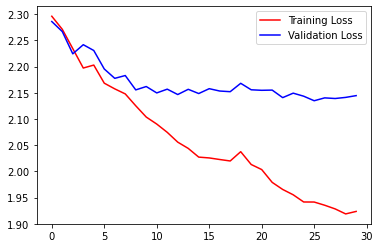

 > Epochs:  30%|███       | 30/100 [00:25<01:00,  1.15it/s]

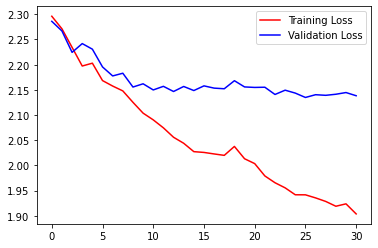

 > Epochs:  31%|███       | 31/100 [00:26<00:59,  1.15it/s]

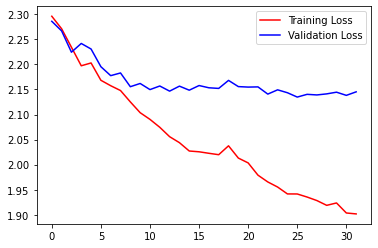

 > Epochs:  32%|███▏      | 32/100 [00:27<00:58,  1.16it/s]

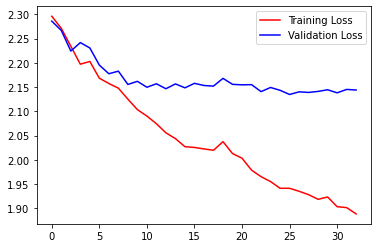

 > Epochs:  33%|███▎      | 33/100 [00:28<00:57,  1.16it/s]

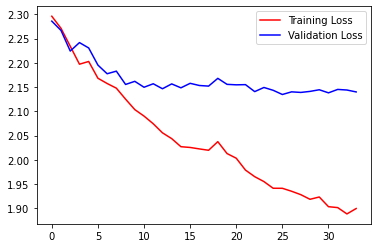

 > Epochs:  34%|███▍      | 34/100 [00:29<00:56,  1.16it/s]

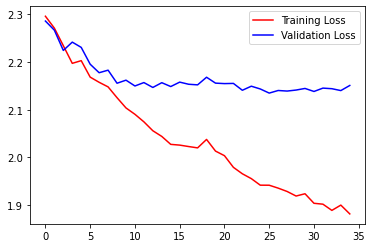

 > Epochs:  35%|███▌      | 35/100 [00:30<00:55,  1.17it/s]

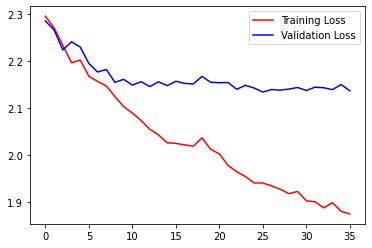

 > Epochs:  36%|███▌      | 36/100 [00:30<00:54,  1.17it/s]

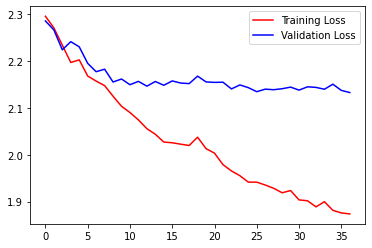

 > Epochs:  37%|███▋      | 37/100 [00:31<00:54,  1.17it/s]

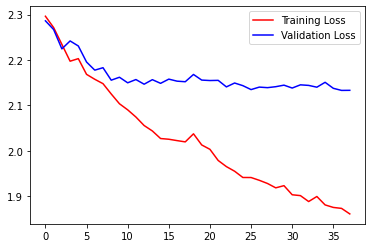

 > Epochs:  38%|███▊      | 38/100 [00:32<00:53,  1.17it/s]

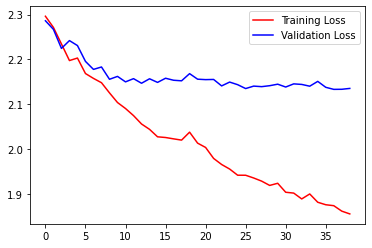

 > Epochs:  39%|███▉      | 39/100 [00:33<00:54,  1.12it/s]

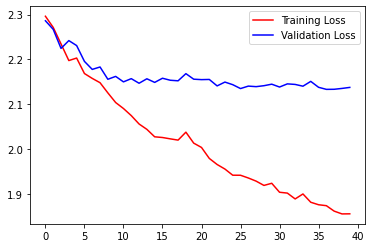

 > Epochs:  39%|███▉      | 39/100 [00:34<00:53,  1.13it/s]



Early stopping enabled




In [48]:
dataloader = extract_dataset(BATCH_SIZE)

network = ClassificationNetwork(IN_CHANNELS, OUT_CHANNELS, KERNEL_SIZE, POOL_SIZE, N_CLASSES).cpu()
network.apply(init_weights_xavier)

loss_function = nn.CrossEntropyLoss
optimizer = optim.Adam(network.parameters(),
                       lr=LEARNING_RATE,
                       weight_decay=WEIGHT_DECAY)

# Model class
nn_model = Model(name = model_name,
                 network = network,
                 dataloader = subset_dataloader, # subset_dataloader just for showing fast result, it would contain the entire training data
                 loss_function = loss_function,
                 seed = seed,
                 save_dir = save_dir,
                 )

nn_model.load_optimizer(optimizer=Adam,
                        lr=LEARNING_RATE,
                        weight_decay=WEIGHT_DECAY)

# Training
nn_model.train(EPOCHS, patience=3)